# Clasificación de impagos de préstamos en un banco

Vamos a implementar un modelo para detectar impagos en los préstamos de un banco

## Índice

1. [Conexión a la base de datos](#mysql)
2. [Feature Extraction](#feature_extraction)
4. [Feature selection](#correlation)
5. [Transformation](#transformation)
6. [Modeling](#modeling)
7. [Feature Importance](#feature_importance)
8. [Próximos pasos](#future)

<a name='mysql'></a>
## 1. Conexión a la base de datos

In [1]:
import pymysql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [72]:
database_host = 'relational.fit.cvut.cz'
username = 'guest'
password = 'relational'
database_name = 'financial'

db = pymysql.connect(host = database_host,
                     user = username,
                     password = password,
                     database = database_name)

In [73]:
query = "SHOW TABLES"
df = pd.read_sql(query,db)
df

,Tables_in_financial
0,account
1,card
2,client
3,disp
4,district
5,loan
6,order
7,trans


<a name='feature_extraction'></a>
## 2. Extracción de variables

De las tablas **loan**, **account** y **district** extrae las siguientes variables en una única tabla
- identificador de la cuenta
- fecha del préstamo
- cantidad del préstamo
- duración del préstamo
- pagos mensuales
- estado del préstamo
- frecuencia de los extractos bancarios
- fecha de creación de la cuenta
- nº de habitantes del distrito
- variables del distrito (A4, A11, A12, A13, A14, A15, A16)

In [3]:
query = '''
SELECT loan.account_id,
       loan.date AS date_loan,
       amount,
       duration,
       payments,
       status,
       frequency,
       account.date AS date_acc,
       A4, A11, A12, A13, A14, A15, A16

FROM loan
JOIN account
ON loan.account_id = account.account_id
JOIN district
ON account.district_id = district.district_id
'''
df = pd.read_sql(query,db)
df

,account_id,date_loan,amount,duration,payments,status,frequency,date_acc,A4,A11,A12,A13,A14,A15,A16
0,2,1994-01-05,80952,24,3373.0,A,POPLATEK MESICNE,1993-02-26,1204953,12541,0.2,0.43,167,85677.0,99107
1,19,1996-04-29,30276,12,2523.0,B,POPLATEK MESICNE,1995-04-07,103347,9104,1.5,2.07,123,2299.0,2354
2,25,1997-12-08,30276,12,2523.0,A,POPLATEK MESICNE,1996-07-28,228848,9893,4.0,4.72,96,5623.0,5887
3,37,1998-10-14,318480,60,5308.0,D,POPLATEK MESICNE,1997-08-18,70646,8547,2.6,3.64,120,1563.0,1542
4,38,1998-04-19,110736,48,2307.0,C,POPLATEK TYDNE,1997-08-08,51428,8402,3.1,3.98,120,999.0,1099
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,1998-09-27,39168,24,1632.0,C,POPLATEK MESICNE,1997-10-15,94725,9920,2.2,2.87,130,4289.0,4846
678,11328,1998-07-18,280440,60,4674.0,C,POPLATEK MESICNE,1996-11-05,387570,9897,1.6,1.96,140,18721.0,18696
679,11349,1995-10-29,419880,60,6998.0,C,POPLATEK TYDNE,1995-05-26,1204953,12541,0.2,0.43,167,85677.0,99107
680,11359,1996-08-06,54024,12,4502.0,A,POPLATEK MESICNE,1994-10-01,117897,8814,4.7,5.74,107,2112.0,2059


Transforma las fechas con `pandas.to_datetime`

In [4]:
df['date_loan'] = pd.to_datetime(df.date_loan,format='%Y-%m-%d')
df['date_acc'] = pd.to_datetime(df.date_acc,format='%Y-%m-%d')

Crea la variable `days_between` como la diferencia de días entre la fecha del préstamo y la fecha creación de la cuenta

In [5]:
df['days_between'] = (df.date_loan-df.date_acc).dt.days

Renombra las variables relacionadas con el distrito y crea la variable del ratio de crímenes por habitante

In [6]:
df['n_inhabitants'] = df.A4
df['average_salary'] = df.A11
df['average_unemployment_rate'] = df[['A12', 'A13']].mean(axis=1)
df['entrepreneur_rate'] = df['A14']
df['average_crime_rate'] = df[['A15','A16']].mean(axis=1) / df['n_inhabitants']

Crea el target binario

In [7]:
df['Target'] = (df['status']=='B') | (df['status']=='D')

In [8]:
df

,account_id,date_loan,amount,duration,payments,status,frequency,date_acc,A4,A11,...,A14,A15,A16,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,Target
0,2,1994-01-05,80952,24,3373.0,A,POPLATEK MESICNE,1993-02-26,1204953,12541,...,167,85677.0,99107,313,1204953,12541,0.315,167,0.076677,False
1,19,1996-04-29,30276,12,2523.0,B,POPLATEK MESICNE,1995-04-07,103347,9104,...,123,2299.0,2354,388,103347,9104,1.785,123,0.022512,True
2,25,1997-12-08,30276,12,2523.0,A,POPLATEK MESICNE,1996-07-28,228848,9893,...,96,5623.0,5887,498,228848,9893,4.360,96,0.025148,False
3,37,1998-10-14,318480,60,5308.0,D,POPLATEK MESICNE,1997-08-18,70646,8547,...,120,1563.0,1542,422,70646,8547,3.120,120,0.021976,True
4,38,1998-04-19,110736,48,2307.0,C,POPLATEK TYDNE,1997-08-08,51428,8402,...,120,999.0,1099,254,51428,8402,3.540,120,0.020397,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,1998-09-27,39168,24,1632.0,C,POPLATEK MESICNE,1997-10-15,94725,9920,...,130,4289.0,4846,347,94725,9920,2.535,130,0.048219,False
678,11328,1998-07-18,280440,60,4674.0,C,POPLATEK MESICNE,1996-11-05,387570,9897,...,140,18721.0,18696,620,387570,9897,1.780,140,0.048271,False
679,11349,1995-10-29,419880,60,6998.0,C,POPLATEK TYDNE,1995-05-26,1204953,12541,...,167,85677.0,99107,156,1204953,12541,0.315,167,0.076677,False
680,11359,1996-08-06,54024,12,4502.0,A,POPLATEK MESICNE,1994-10-01,117897,8814,...,107,2112.0,2059,675,117897,8814,5.220,107,0.017689,False


In [9]:
df.account_id.nunique()

682

De la tabla **trans** obtén, para cada cuenta, la cantidad transferida y el balance

In [22]:
query = '''
SELECT trans.account_id, trans.amount as trans_amount, balance as trans_balance 
FROM trans
JOIN loan
ON trans.account_id = loan.account_id
AND trans.date < loan.date
'''
df_trans = pd.read_sql(query,db)
df_trans

,account_id,trans_amount,trans_balance
0,2,1100,1100
1,2,20236,21336
2,2,20236,45286
3,2,20236,54631
4,2,30354,67530
...,...,...,...
54689,11362,93,17922
54690,11362,75,14889
54691,11362,73,15993
54692,11362,87,19331


Cuenta el número de transacciones de cada cuenta

In [23]:
# account_id | n_trans
#    2          54
n_trans = df_trans[['account_id','trans_amount']].groupby('account_id',
                                                         as_index=False).count()
n_trans.columns=['account_id','n_trans']
n_trans

,account_id,n_trans
0,2,54
1,19,80
2,25,164
3,37,116
4,38,55
...,...,...
677,11327,54
678,11328,106
679,11349,18
680,11359,147


Calcula la media de cantidad y balance de las transacciones para cada cuenta

In [24]:
df_trans2 = df_trans.groupby('account_id',as_index=False).mean()
df_trans2

,account_id,trans_amount,trans_balance
0,2,7954.333333,32590.759259
1,19,5856.350000,25197.137500
2,25,12113.981707,62991.408537
3,37,7572.034483,39954.034483
4,38,4716.200000,31383.581818
...,...,...,...
677,11327,7977.981481,55438.814815
678,11328,8138.754717,38619.084906
679,11349,24426.500000,59352.666667
680,11359,8708.775510,36480.238095


Une todos estos datos con el dataframe general

In [25]:
df = df.merge(df_trans2,how='left',
              left_on='account_id',right_on='account_id').merge(n_trans,how='left',
                                                               left_on='account_id',
                                                               right_on='account_id')
df

,account_id,date_loan,amount,duration,payments,status,frequency,date_acc,A4,A11,...,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,Target,trans_amount,trans_balance,n_trans
0,2,1994-01-05,80952,24,3373.0,A,POPLATEK MESICNE,1993-02-26,1204953,12541,...,313,1204953,12541,0.315,167,0.076677,False,7954.333333,32590.759259,54
1,19,1996-04-29,30276,12,2523.0,B,POPLATEK MESICNE,1995-04-07,103347,9104,...,388,103347,9104,1.785,123,0.022512,True,5856.350000,25197.137500,80
2,25,1997-12-08,30276,12,2523.0,A,POPLATEK MESICNE,1996-07-28,228848,9893,...,498,228848,9893,4.360,96,0.025148,False,12113.981707,62991.408537,164
3,37,1998-10-14,318480,60,5308.0,D,POPLATEK MESICNE,1997-08-18,70646,8547,...,422,70646,8547,3.120,120,0.021976,True,7572.034483,39954.034483,116
4,38,1998-04-19,110736,48,2307.0,C,POPLATEK TYDNE,1997-08-08,51428,8402,...,254,51428,8402,3.540,120,0.020397,False,4716.200000,31383.581818,55
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,1998-09-27,39168,24,1632.0,C,POPLATEK MESICNE,1997-10-15,94725,9920,...,347,94725,9920,2.535,130,0.048219,False,7977.981481,55438.814815,54
678,11328,1998-07-18,280440,60,4674.0,C,POPLATEK MESICNE,1996-11-05,387570,9897,...,620,387570,9897,1.780,140,0.048271,False,8138.754717,38619.084906,106
679,11349,1995-10-29,419880,60,6998.0,C,POPLATEK TYDNE,1995-05-26,1204953,12541,...,156,1204953,12541,0.315,167,0.076677,False,24426.500000,59352.666667,18
680,11359,1996-08-06,54024,12,4502.0,A,POPLATEK MESICNE,1994-10-01,117897,8814,...,675,117897,8814,5.220,107,0.017689,False,8708.775510,36480.238095,147


De la tabla **card**, añade el tipo de tarjeta para cada cuenta (solo titulares)

In [26]:
query = '''
SELECT disp.account_id, card.type as card_type
FROM card
JOIN disp
ON card.disp_id = disp.disp_id
JOIN loan
ON disp.account_id = loan.account_id
AND card.issued < loan.date
WHERE disp.type= 'OWNER'
'''
df_card = pd.read_sql(query,db)
df_card

,account_id,card_type
0,105,classic
1,226,classic
2,276,classic
3,544,classic
4,666,classic
5,1480,classic
6,1766,classic
7,1869,classic
8,2116,classic
9,2262,classic


Une la tabla anterior a la general. Para aquellas cuentas sin tarjeta, ponle el valor "No"

In [27]:
df = df.merge(df_card, how='left', left_on='account_id',right_on='account_id')
df['card_type'].fillna('No',inplace=True)
df

,account_id,date_loan,amount,duration,payments,status,frequency,date_acc,A4,A11,...,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,Target,trans_amount,trans_balance,n_trans,card_type
0,2,1994-01-05,80952,24,3373.0,A,POPLATEK MESICNE,1993-02-26,1204953,12541,...,1204953,12541,0.315,167,0.076677,False,7954.333333,32590.759259,54,No
1,19,1996-04-29,30276,12,2523.0,B,POPLATEK MESICNE,1995-04-07,103347,9104,...,103347,9104,1.785,123,0.022512,True,5856.350000,25197.137500,80,No
2,25,1997-12-08,30276,12,2523.0,A,POPLATEK MESICNE,1996-07-28,228848,9893,...,228848,9893,4.360,96,0.025148,False,12113.981707,62991.408537,164,No
3,37,1998-10-14,318480,60,5308.0,D,POPLATEK MESICNE,1997-08-18,70646,8547,...,70646,8547,3.120,120,0.021976,True,7572.034483,39954.034483,116,No
4,38,1998-04-19,110736,48,2307.0,C,POPLATEK TYDNE,1997-08-08,51428,8402,...,51428,8402,3.540,120,0.020397,False,4716.200000,31383.581818,55,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,1998-09-27,39168,24,1632.0,C,POPLATEK MESICNE,1997-10-15,94725,9920,...,94725,9920,2.535,130,0.048219,False,7977.981481,55438.814815,54,No
678,11328,1998-07-18,280440,60,4674.0,C,POPLATEK MESICNE,1996-11-05,387570,9897,...,387570,9897,1.780,140,0.048271,False,8138.754717,38619.084906,106,No
679,11349,1995-10-29,419880,60,6998.0,C,POPLATEK TYDNE,1995-05-26,1204953,12541,...,1204953,12541,0.315,167,0.076677,False,24426.500000,59352.666667,18,No
680,11359,1996-08-06,54024,12,4502.0,A,POPLATEK MESICNE,1994-10-01,117897,8814,...,117897,8814,5.220,107,0.017689,False,8708.775510,36480.238095,147,classic


De la tabla **client**, obtén la edad de los clientes (en el momento del préstamo), su sexo y añade una variable binaria que indique si el distrito del cliente coincide con el distrito de la cuenta

In [28]:
query = '''
SELECT account_id,
       loan.date as loan_date,
       account.district_id as acc_dist_id,
       client.district_id as cli_dist_id,
       gender as owner_gender,
       birth_date

FROM loan
JOIN account using(account_id)
JOIN disp using(account_id)
JOIN client using(client_id)

WHERE disp.type = 'OWNER'
'''
df_cli = pd.read_sql(query,db)
df_cli

,account_id,loan_date,acc_dist_id,cli_dist_id,owner_gender,birth_date
0,2,1994-01-05,1,1,M,1945-02-04
1,19,1996-04-29,21,21,F,1939-04-23
2,25,1997-12-08,68,68,M,1962-02-09
3,37,1998-10-14,20,20,M,1952-08-26
4,38,1998-04-19,19,19,F,1940-01-30
...,...,...,...,...,...,...
677,11327,1998-09-27,7,7,F,1979-02-22
678,11328,1998-07-18,54,54,F,1952-09-09
679,11349,1995-10-29,1,1,F,1945-10-30
680,11359,1996-08-06,61,61,M,1968-04-13


In [29]:
df_cli['same_district'] = df_cli['acc_dist_id'] == df_cli['cli_dist_id']
df_cli['loan_date'] = pd.to_datetime(df_cli['loan_date'],format='%Y-%m-%d')
df_cli['birth_date'] = pd.to_datetime(df_cli['birth_date'],format='%Y-%m-%d')
df_cli['owner_age'] = (df_cli.loan_date-df_cli.birth_date).dt.days//365
df_cli

,account_id,loan_date,acc_dist_id,cli_dist_id,owner_gender,birth_date,same_district,owner_age
0,2,1994-01-05,1,1,M,1945-02-04,True,48
1,19,1996-04-29,21,21,F,1939-04-23,True,57
2,25,1997-12-08,68,68,M,1962-02-09,True,35
3,37,1998-10-14,20,20,M,1952-08-26,True,46
4,38,1998-04-19,19,19,F,1940-01-30,True,58
...,...,...,...,...,...,...,...,...
677,11327,1998-09-27,7,7,F,1979-02-22,True,19
678,11328,1998-07-18,54,54,F,1952-09-09,True,45
679,11349,1995-10-29,1,1,F,1945-10-30,True,50
680,11359,1996-08-06,61,61,M,1968-04-13,True,28


Une la tabla anterior con la general

In [30]:
df = df.merge(df_cli,left_on='account_id',right_on='account_id')
df

,account_id,date_loan,amount,duration,payments,status,frequency,date_acc,A4,A11,...,trans_balance,n_trans,card_type,loan_date,acc_dist_id,cli_dist_id,owner_gender,birth_date,same_district,owner_age
0,2,1994-01-05,80952,24,3373.0,A,POPLATEK MESICNE,1993-02-26,1204953,12541,...,32590.759259,54,No,1994-01-05,1,1,M,1945-02-04,True,48
1,19,1996-04-29,30276,12,2523.0,B,POPLATEK MESICNE,1995-04-07,103347,9104,...,25197.137500,80,No,1996-04-29,21,21,F,1939-04-23,True,57
2,25,1997-12-08,30276,12,2523.0,A,POPLATEK MESICNE,1996-07-28,228848,9893,...,62991.408537,164,No,1997-12-08,68,68,M,1962-02-09,True,35
3,37,1998-10-14,318480,60,5308.0,D,POPLATEK MESICNE,1997-08-18,70646,8547,...,39954.034483,116,No,1998-10-14,20,20,M,1952-08-26,True,46
4,38,1998-04-19,110736,48,2307.0,C,POPLATEK TYDNE,1997-08-08,51428,8402,...,31383.581818,55,No,1998-04-19,19,19,F,1940-01-30,True,58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,11327,1998-09-27,39168,24,1632.0,C,POPLATEK MESICNE,1997-10-15,94725,9920,...,55438.814815,54,No,1998-09-27,7,7,F,1979-02-22,True,19
678,11328,1998-07-18,280440,60,4674.0,C,POPLATEK MESICNE,1996-11-05,387570,9897,...,38619.084906,106,No,1998-07-18,54,54,F,1952-09-09,True,45
679,11349,1995-10-29,419880,60,6998.0,C,POPLATEK TYDNE,1995-05-26,1204953,12541,...,59352.666667,18,No,1995-10-29,1,1,F,1945-10-30,True,50
680,11359,1996-08-06,54024,12,4502.0,A,POPLATEK MESICNE,1994-10-01,117897,8814,...,36480.238095,147,classic,1996-08-06,61,61,M,1968-04-13,True,28


### Tablón final

In [31]:
df_ml = df[['amount', 'duration', 'payments', 'days_between', 'n_inhabitants', 
            'average_salary', 'average_unemployment_rate', 'entrepreneur_rate', 
            'average_crime_rate','trans_amount','trans_balance',
            'n_trans', 'owner_age', 
            'frequency', 'card_type', 'same_district', 'owner_gender', 'Target']]
df_ml

,amount,duration,payments,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,trans_amount,trans_balance,n_trans,owner_age,frequency,card_type,same_district,owner_gender,Target
0,80952,24,3373.0,313,1204953,12541,0.315,167,0.076677,7954.333333,32590.759259,54,48,POPLATEK MESICNE,No,True,M,False
1,30276,12,2523.0,388,103347,9104,1.785,123,0.022512,5856.350000,25197.137500,80,57,POPLATEK MESICNE,No,True,F,True
2,30276,12,2523.0,498,228848,9893,4.360,96,0.025148,12113.981707,62991.408537,164,35,POPLATEK MESICNE,No,True,M,False
3,318480,60,5308.0,422,70646,8547,3.120,120,0.021976,7572.034483,39954.034483,116,46,POPLATEK MESICNE,No,True,M,True
4,110736,48,2307.0,254,51428,8402,3.540,120,0.020397,4716.200000,31383.581818,55,58,POPLATEK TYDNE,No,True,F,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,39168,24,1632.0,347,94725,9920,2.535,130,0.048219,7977.981481,55438.814815,54,19,POPLATEK MESICNE,No,True,F,False
678,280440,60,4674.0,620,387570,9897,1.780,140,0.048271,8138.754717,38619.084906,106,45,POPLATEK MESICNE,No,True,F,False
679,419880,60,6998.0,156,1204953,12541,0.315,167,0.076677,24426.500000,59352.666667,18,50,POPLATEK TYDNE,No,True,F,False
680,54024,12,4502.0,675,117897,8814,5.220,107,0.017689,8708.775510,36480.238095,147,28,POPLATEK MESICNE,classic,True,M,False


In [73]:
df_ml.sample(5)

,amount,duration,payments,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,trans_amount,trans_balance,n_trans,owner_age,frequency,card_type,same_district,owner_gender,Target
544,164256,48,3422.0,468,75637,9622,0.495,154,0.046300,8080.285714,42341.704082,98,24,POPLATEK MESICNE,No,True,M,False
14,160920,36,4470.0,359,85852,8965,7.615,104,0.031886,11120.627119,51649.440678,59,27,POPLATEK MESICNE,classic,True,M,False
384,212400,36,5900.0,391,85852,8965,7.615,104,0.031886,11301.591549,51034.366197,71,27,POPLATEK TYDNE,No,True,F,False
513,33144,12,2762.0,182,285387,10177,7.175,81,0.035016,5645.500000,32407.625000,32,17,POPLATEK MESICNE,No,True,F,False
672,89280,12,7440.0,261,1204953,12541,0.315,167,0.076677,15233.653846,60522.134615,52,49,POPLATEK MESICNE,No,True,M,False


In [32]:
df_ml.isnull().sum()

amount                       0
duration                     0
payments                     0
days_between                 0
n_inhabitants                0
average_salary               0
average_unemployment_rate    0
entrepreneur_rate            0
average_crime_rate           0
trans_amount                 0
trans_balance                0
n_trans                      0
owner_age                    0
frequency                    0
card_type                    0
same_district                0
owner_gender                 0
Target                       0
dtype: int64

In [33]:
df.describe()

,account_id,amount,duration,payments,A4,A11,A12,A13,A14,A15,...,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,trans_amount,trans_balance,n_trans,acc_dist_id,cli_dist_id,owner_age
count,682.000000,682.000000,682.000000,682.000000,6.820000e+02,682.000000,674.000000,682.000000,682.000000,674.000000,...,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000
mean,5824.162757,151410.175953,36.492669,4190.664223,2.720522e+05,9502.986804,2.842136,3.528431,121.218475,14861.621662,...,9502.986804,3.209729,121.218475,0.036224,9488.694238,43606.833097,80.196481,37.489736,38.043988,37.653959
std,3283.512681,113372.406310,17.075219,2215.830344,3.583320e+05,1323.150982,1.881095,2.146775,23.366091,27072.441726,...,1323.150982,2.029293,23.366091,0.018186,4445.464366,13481.860726,44.777664,25.184326,25.029929,12.774926
min,2.000000,4980.000000,12.000000,304.000000,4.282100e+04,8110.000000,0.200000,0.430000,81.000000,818.000000,...,8110.000000,0.315000,81.000000,0.014744,1566.921212,5350.000000,2.000000,1.000000,1.000000,13.000000
25%,2967.000000,66732.000000,24.000000,2477.000000,9.208400e+04,8544.000000,1.500000,1.960000,106.000000,2166.000000,...,8544.000000,1.780000,106.000000,0.022194,6021.832603,32833.081400,45.000000,13.000000,14.000000,27.000000
50%,5738.500000,116928.000000,36.000000,3934.000000,1.246050e+05,8991.000000,2.700000,3.490000,116.000000,3732.500000,...,8991.000000,3.075000,116.000000,0.031713,8942.016026,43159.288363,77.000000,39.000000,40.000000,37.000000
75%,8686.000000,210654.000000,48.000000,5813.500000,2.261220e+05,9897.000000,3.950000,4.790000,132.000000,6949.000000,...,9897.000000,4.360000,132.000000,0.042703,12557.855482,53614.015301,112.000000,60.000000,60.000000,48.000000
max,11362.000000,590820.000000,60.000000,9910.000000,1.204953e+06,12541.000000,7.300000,9.400000,167.000000,85677.000000,...,12541.000000,8.350000,167.000000,0.076677,26978.866667,79500.529762,218.000000,77.000000,77.000000,61.000000


<a name='transformation'></a>
## 3. Transformaciones

Convierte las categóricas mediante one-hot encoding

In [34]:
df_ml2 = pd.get_dummies(df_ml,columns=['frequency','card_type'])
df_ml2['same_district'] = df_ml2.same_district.astype('int')
df_ml2['Target'] = df_ml2.Target.astype('int')
df_ml2['owner_gender'] = df_ml2.owner_gender.map({'F':1, 'M':0})
df_ml2

,amount,duration,payments,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,trans_amount,...,same_district,owner_gender,Target,frequency_POPLATEK MESICNE,frequency_POPLATEK PO OBRATU,frequency_POPLATEK TYDNE,card_type_No,card_type_classic,card_type_gold,card_type_junior
0,80952,24,3373.0,313,1204953,12541,0.315,167,0.076677,7954.333333,...,1,0,0,1,0,0,1,0,0,0
1,30276,12,2523.0,388,103347,9104,1.785,123,0.022512,5856.350000,...,1,1,1,1,0,0,1,0,0,0
2,30276,12,2523.0,498,228848,9893,4.360,96,0.025148,12113.981707,...,1,0,0,1,0,0,1,0,0,0
3,318480,60,5308.0,422,70646,8547,3.120,120,0.021976,7572.034483,...,1,0,1,1,0,0,1,0,0,0
4,110736,48,2307.0,254,51428,8402,3.540,120,0.020397,4716.200000,...,1,1,0,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
677,39168,24,1632.0,347,94725,9920,2.535,130,0.048219,7977.981481,...,1,1,0,1,0,0,1,0,0,0
678,280440,60,4674.0,620,387570,9897,1.780,140,0.048271,8138.754717,...,1,1,0,1,0,0,1,0,0,0
679,419880,60,6998.0,156,1204953,12541,0.315,167,0.076677,24426.500000,...,1,1,0,0,0,1,1,0,0,0
680,54024,12,4502.0,675,117897,8814,5.220,107,0.017689,8708.775510,...,1,0,0,1,0,0,0,1,0,0


In [35]:
df_ml2.describe()

,amount,duration,payments,days_between,n_inhabitants,average_salary,average_unemployment_rate,entrepreneur_rate,average_crime_rate,trans_amount,...,same_district,owner_gender,Target,frequency_POPLATEK MESICNE,frequency_POPLATEK PO OBRATU,frequency_POPLATEK TYDNE,card_type_No,card_type_classic,card_type_gold,card_type_junior
count,682.000000,682.000000,682.000000,682.000000,6.820000e+02,682.000000,682.000000,682.000000,682.000000,682.000000,...,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000,682.000000
mean,151410.175953,36.492669,4190.664223,398.240469,2.720522e+05,9502.986804,3.209729,121.218475,0.036224,9488.694238,...,0.912023,0.510264,0.111437,0.819648,0.046921,0.133431,0.947214,0.041056,0.004399,0.007331
std,113372.406310,17.075219,2215.830344,164.611359,3.583320e+05,1323.150982,2.029293,23.366091,0.018186,4445.464366,...,0.283469,0.500262,0.314903,0.384762,0.211624,0.340290,0.223770,0.198565,0.066226,0.085372
min,4980.000000,12.000000,304.000000,102.000000,4.282100e+04,8110.000000,0.315000,81.000000,0.014744,1566.921212,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,66732.000000,24.000000,2477.000000,261.250000,9.208400e+04,8544.000000,1.780000,106.000000,0.022194,6021.832603,...,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
50%,116928.000000,36.000000,3934.000000,395.500000,1.246050e+05,8991.000000,3.075000,116.000000,0.031713,8942.016026,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,210654.000000,48.000000,5813.500000,528.750000,2.261220e+05,9897.000000,4.360000,132.000000,0.042703,12557.855482,...,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,590820.000000,60.000000,9910.000000,697.000000,1.204953e+06,12541.000000,8.350000,167.000000,0.076677,26978.866667,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


<a name='train-test'></a>
## 4. División train-test

In [36]:
X = df_ml2.drop(columns=['Target'])
y = df_ml2['Target']

In [37]:
from sklearn.model_selection import train_test_split

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,
                                                   random_state=1,stratify=y)

In [39]:
X_train.shape, X_test.shape

((477, 22), (205, 22))

In [40]:
y_train.value_counts()

0    424
1     53
Name: Target, dtype: int64

In [41]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_sm, y_sm = sm.fit_resample(X_train,y_train)

In [42]:
y_sm.value_counts()

1    424
0    424
Name: Target, dtype: int64

<a name='correlation'></a>
## 5. Selección de variables

Aplica técnicas para seleccionar las variables de entrada al modelo

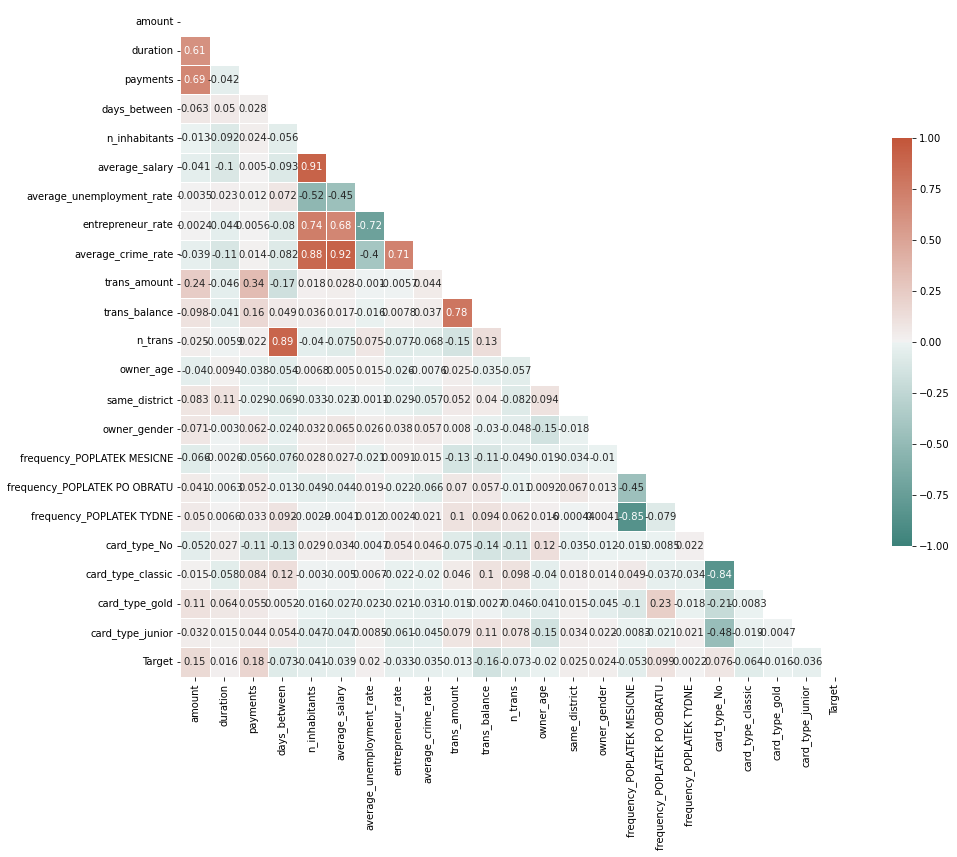

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

correlation = pd.concat([X_train,y_train],axis=1).corr() 

mask = np.zeros_like(correlation, dtype=bool)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 15))

cmap = sns.diverging_palette(180, 20, as_cmap=True)
sns.heatmap(correlation, mask=mask, cmap=cmap, vmax=1, vmin =-1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

<AxesSubplot:xlabel='average_crime_rate', ylabel='average_salary'>

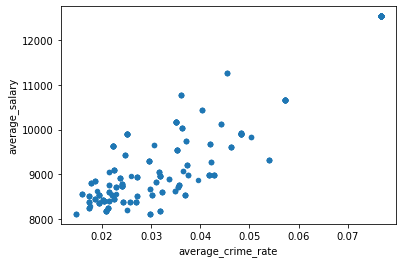

In [44]:
X_train.plot.scatter(x='average_crime_rate',y='average_salary')

In [45]:
from sklearn.feature_selection import SelectKBest, f_classif

sel = SelectKBest(f_classif,k=5)
X_new = sel.fit_transform(X_train,y_train)
print(X_new.shape)
pd.DataFrame({'variable':X_train.columns,
             'score':sel.scores_}).sort_values('score',ascending=False)

(477, 5)


,variable,score
2,payments,16.384244
10,trans_balance,11.796571
0,amount,11.651313
16,frequency_POPLATEK PO OBRATU,4.657673
18,card_type_No,2.750207
3,days_between,2.534275
11,n_trans,2.525856
19,card_type_classic,1.935615
15,frequency_POPLATEK MESICNE,1.353276
4,n_inhabitants,0.780698


In [93]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train, y_train)
scores = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), X_train.columns), reverse=True)
pd.DataFrame(scores, columns=['Score', 'Feature'])

,Score,Feature
0,0.1246,payments
1,0.1175,trans_balance
2,0.0998,amount
3,0.0915,n_trans
4,0.0763,days_between
5,0.0758,trans_amount
6,0.0723,owner_age
7,0.0591,average_salary
8,0.0554,n_inhabitants
9,0.0512,average_unemployment_rate


<a name='modeling'></a>
## 6. Modelado

Entrena uno o varios modelos, dividiendo el conjunto en train-test 

In [48]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

estimator = XGBClassifier(seed=42)

parameters = {
 'max_depth':[3],
 'min_child_weight':[3],
 'gamma':[0.2],
 'subsample':[0.9],
 'colsample_bytree':[0.5],
 'reg_alpha':[1e-3]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'f1',
    n_jobs = -1,
    cv = 10,
    verbose=1
)

grid_search.fit(X_sm,y_sm)


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[14:02:39] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\rzambrano\Anaconda3\envs\general\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None...
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     seed=42, subsample=No

In [49]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0.2, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0.001, reg_lambda=1,
              scale_pos_weight=1, seed=42, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [50]:
grid_search.best_score_

0.9198910584153464

In [51]:
grid_search.best_estimator_.score(X_test,y_test)

0.8146341463414634

### Medición del desempeño

Utiliza las méticas de desempeño de los modelos de clasificación binarios, en el conjunto de train y test

In [52]:
ypred = grid_search.best_estimator_.predict(X_test)
ypred

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0])

In [53]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,ypred))
confusion_matrix(y_test,ypred)

              precision    recall  f1-score   support

           0       0.90      0.89      0.90       182
           1       0.20      0.22      0.21        23

    accuracy                           0.81       205
   macro avg       0.55      0.55      0.55       205
weighted avg       0.82      0.81      0.82       205



array([[162,  20],
       [ 18,   5]], dtype=int64)

In [54]:
y_test.value_counts()

0    182
1     23
Name: Target, dtype: int64

C:\Users\rzambrano\Anaconda3\envs\general\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


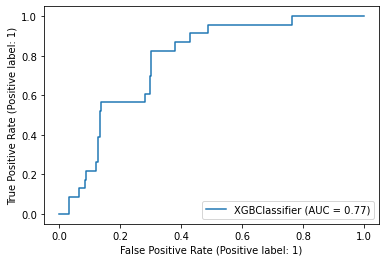

In [55]:
from sklearn import metrics
metrics.plot_roc_curve(grid_search.best_estimator_, X_test,y_test)

### Do it yourself

1. Calcula el accuracy para el TOP 10% de clientes según el score del modelo
2. Implementa un modelo de propensión a contratar préstamos

In [59]:
ypred_prob = grid_search.best_estimator_.predict_proba(X_test)[:,1]
ypred_prob

array([7.58030951e-01, 3.09572835e-03, 1.02327939e-03, 3.03880647e-02,
       2.54260391e-01, 7.63909286e-03, 7.28907362e-02, 4.77650225e-01,
       5.23246378e-02, 6.89676702e-02, 3.87609303e-02, 1.04805026e-02,
       8.70261312e-01, 9.88765038e-04, 4.79538254e-02, 8.37142885e-01,
       6.48614913e-02, 3.53860021e-01, 8.73303786e-02, 8.85839164e-02,
       1.07353227e-03, 5.07539734e-02, 1.03678685e-02, 5.45207374e-02,
       4.66706511e-03, 6.68043077e-01, 4.56057191e-02, 1.04148975e-02,
       9.68711153e-02, 7.61537611e-01, 6.73568010e-01, 9.15843308e-01,
       3.33583303e-04, 5.00456020e-02, 1.19198370e-03, 7.26352692e-01,
       6.09462447e-02, 5.38302287e-02, 2.12574489e-02, 3.65696126e-03,
       2.57629529e-03, 4.73473728e-01, 6.61241138e-05, 5.53416423e-02,
       2.88734548e-02, 2.91683152e-03, 1.34128273e-01, 4.02522422e-02,
       2.69639306e-03, 8.89683217e-02, 4.79970165e-02, 7.93489045e-04,
       1.35893270e-01, 1.58783436e-01, 3.93742649e-03, 9.12379548e-02,
      

In [60]:
np.percentile(ypred_prob,90)

0.6267900347709655

In [61]:
df = pd.DataFrame({'Real':y_test,'Pred':ypred,'Prob':ypred_prob})
df

,Real,Pred,Prob
290,0,1,0.758031
31,0,0,0.003096
555,0,0,0.001023
301,0,0,0.030388
577,0,0,0.254260
...,...,...,...
447,0,0,0.102287
169,0,1,0.666289
135,0,0,0.174279
10,0,0,0.021495


In [65]:
df_top10 = df.loc[df.Prob>=np.percentile(df.Prob,90)]
df_top10['Real'].sum()/df_top10.shape[0]

0.23809523809523808

In [67]:
y_test.value_counts(normalize=True)

0    0.887805
1    0.112195
Name: Target, dtype: float64

In [68]:
0.238/0.112

2.125

In [63]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(df_top10.Real,df_top10.Pred))
confusion_matrix(df_top10.Real,df_top10.Pred)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        16
           1       0.24      1.00      0.38         5

    accuracy                           0.24        21
   macro avg       0.12      0.50      0.19        21
weighted avg       0.06      0.24      0.09        21



C:\Users\rzambrano\Anaconda3\envs\general\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rzambrano\Anaconda3\envs\general\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\rzambrano\Anaconda3\envs\general\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


array([[ 0, 16],
       [ 0,  5]], dtype=int64)